### dset check
1. check pair-wise image and truth 
2. check the distribution of the dset. 

In [1]:
import os 
print(os.getcwd())
os.chdir('..')
import glob
import numpy as np
import rasterio as rio
from rasterio.crs import CRS
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
from utils.imgShow import imsShow
from utils.transform_xy import coor2coor


/home/xin/Developer-kang/glacier_mapping/notebooks


In [2]:
### get the labeled landsat and sentinel images
# paths_truth = sorted(glob.glob('data/dset-l5789-s2/truth/*.tif'))
# paths_scene = [path_truth.replace('.tif', '_Dem.tif').replace('truth','scene') for path_truth in paths_truth]
# names_satellite = [path_truth.split('/')[-1][0:2] for path_truth in paths_truth]

paths_tra_scene = sorted(glob.glob('data/dset-l5789-s2/tra_scene/*.tif'))
paths_tra_truth = sorted(glob.glob('data/dset-l5789-s2/tra_truth/*.tif'))
paths_val_scene = sorted(glob.glob('data/dset-l5789-s2/val_scene/*.tif'))
paths_val_truth = sorted(glob.glob('data/dset-l5789-s2/val_truth/*.tif'))

print(len(paths_tra_scene))
print(len(paths_val_scene))

# Combine the two path lists into one
paths_scene = paths_tra_scene + paths_val_scene
paths_truth = paths_tra_truth + paths_val_truth
names_satellite = [path_truth.split('/')[-1][0:2] for path_truth in paths_truth]
print('Number of scenes:', len(paths_scene))
print('Satellite:', names_satellite[0])


50
15
Number of scenes: 65
Satellite: S2


#### 1. Check the pair-wise sence and truth images


data/dset-l5789-s2/tra_scene/S2_scene_01_Dem.tif


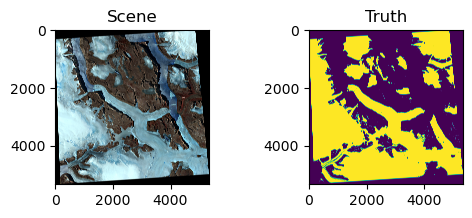

data/dset-l5789-s2/tra_scene/S2_scene_02_Dem.tif


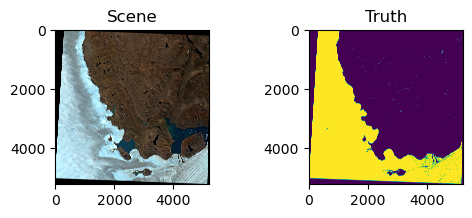

data/dset-l5789-s2/tra_scene/S2_scene_03_Dem.tif


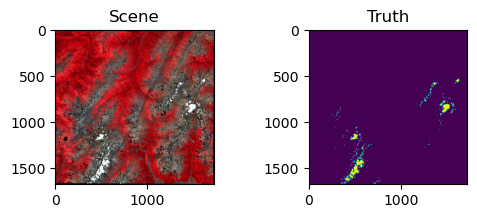

In [3]:
for id_scene in range(len(paths_scene[0:3])):
        # id_scene = 0
        print(paths_scene[id_scene])
        # print(paths_truth[id_scene])
        scene_rio = rio.open(paths_scene[id_scene])
        truth_rio = rio.open(paths_truth[id_scene])
        scene_truth_arr = [scene_rio.read([2,3,4]).transpose(1,2,0), truth_rio.read(1)]
        imsShow(img_list=scene_truth_arr,
                img_name_list=['Scene', 'Truth'], figsize=(6,2))
        plt.show()


#### 2. check the distribution of the dataset


In [4]:
### Get center coordinates (wgs84) of the landsat scenes
centroids_wgs84 = []
for path_truth in paths_truth:
    truth_rio = rio.open(path_truth)
    bounds_truth = truth_rio.bounds
    centroid_lon, centroid_lat= (bounds_truth.left + bounds_truth.right) / 2, (bounds_truth.bottom + bounds_truth.top) / 2
    source_crs = truth_rio.crs 
    target_crs_wgs84 = CRS.from_epsg(4326)

    if source_crs != target_crs_wgs84:
        centroid_lon, centroid_lat = coor2coor(
            crs_from=source_crs,          
            crs_to=target_crs_wgs84,      
            x=centroid_lon, 
            y=centroid_lat
        )       
    centroids_wgs84.append(Point([centroid_lon, centroid_lat]))
print('number of centroids:',len(centroids_wgs84))



number of centroids: 65


In [5]:
dset_gpd = gpd.GeoDataFrame({'satellite':names_satellite}, geometry=centroids_wgs84, crs=4326)
dset_gpd.head()


,satellite,geometry
0,S2,POINT (-41.13680 82.29742)
1,S2,POINT (-23.28181 79.66706)
2,S2,POINT (171.43512 -42.91507)
3,S2,POINT (79.24491 41.94505)
4,S2,POINT (-149.04035 60.74511)


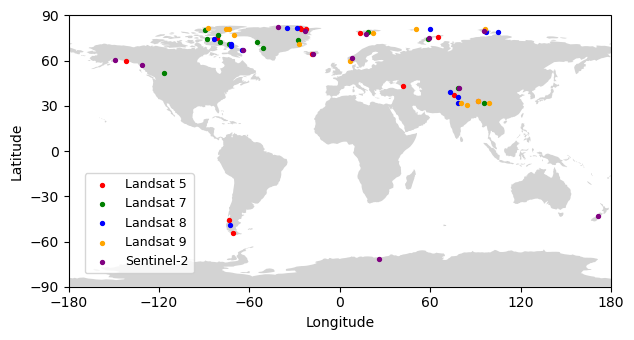

In [6]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
sat_colors = {'l5': 'red', 'l7': 'green', 'l8': 'blue', 'l9': 'orange', 'S2': 'purple'}
ax.add_feature(ccrs.cartopy.feature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])

for sat, color in sat_colors.items():
    data_to_plot = dset_gpd[dset_gpd.satellite == sat]
    if not data_to_plot.empty:
        if sat == 'S2':
            label_text = 'Sentinel-2'
        else:
            label_text = f'Landsat {sat[-1]}'           
        data_to_plot.plot(
            ax=ax, 
            marker='o', 
            markersize=8, 
            color=color, 
            label=label_text,
            aspect='equal'  
        )
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)


In [7]:
path_fig = 'figures/dset_distribution.png'
fig.savefig(path_fig)

